# 本章内容介绍

奇异值分解(Singular Value Decomposition,SVD)常用来简化数据、去除噪声。在这章先介绍SVD的一些应用，再从其算法来分析它为什么有效，然后建立一个基于协同过滤的系统。

# 奇异值分解的应用

在隐性语义索引中(Latent Semantic Indexing，LSI)，我们将一个文档用一个矩阵(term-document)表示，在这个矩阵的基础上运用SVD对其分解，便可以得到它的某个低秩逼近，在这个低秩逼近下，可以为每个文档产生一个新的表示(奇异值)。这些奇异值代表了文档的概念或者主题，因此可以用于加快文档检索。

另一个应用就是推荐系统。SVD可以从数据中构建一个主题空间，然后在这个空间中计算它的相似度。具体的实现将在后面进行讲解。

# 矩阵分解

SVD是矩阵分解的一种类型，矩阵分解的目的是将矩阵分成多个独立的部分。我们可以将这种分解的过程想象成代数中的因子分解。如何将12分解成两个数的乘积？(1,12)(2,6)(3,4)都是合理的答案。

不同矩阵分解技术有不同的性质，运用于不同方面，而SVD则是最常见的一种分解技术。它将矩阵$Data$分解成三个矩阵$U 、\Sigma和V^T$

假如矩阵$Data$的维度是$m \times n$，$U 、\Sigma和V^T$这三个矩阵的维度分别是$m \times m、m \times n 、n \times n$，所以用公式表达就是

$$Data_{m \times n} = U_{m \times m}\Sigma_{m \times n}V^T_{n \times n}$$

其中$\Sigma$是一个对角矩阵，也就是奇异值矩阵，而且其对角元素是从大到小排列的，被称为奇异值。而且在科学和工程中，一直存在着一个普遍的事实：在某个奇异值的数目($r$个)之后，其他奇异值都置为0。这意味着数据集中仅有$r$个重要特征，而其余特征都是噪声或者是冗余特征。$U$被称为左奇异矩阵，$V^T$则是右奇异矩阵，两者都是单位正交矩阵。SVD的目的是，对任意$m\times n$的矩阵，找到一组正交基使得经过它变换后还是正交基。

# 利用Python实现SVD

In [1]:
#导入需要的库与包
import numpy as np
from numpy import linalg

#创建矩阵
Data = np.array([[1,1],[7,7]])

m = Data.shape[0]#矩阵的行数
n = Data.shape[1]#矩阵的列数

#调用linalg包中封装好的SVD算法
U,Sigma,VT = linalg.svd(Data)

print(U)
print(VT)
print(Sigma)

#我们需要构建一个mxn的Sigma矩阵，但是我们并不知道返回的特征值有多少个，因此要在后面补充零
if m > n:
    for i in range(m - len(Sigma)):
        Sigma = np.append(Sigma,0)
else:
    for i in range(n - len(Sigma)):
        Sigma = np.append(Sigma,0)
#注意：linalg为了节省空间，对角矩阵以一维向量返回，因此需使用np.diag将一维向量转换成对角矩阵，然后再取前m行，前n列
print(np.diag(Sigma)[:m,:n])
rData = np.dot(np.dot(U,np.diag(Sigma)[:m,:]),VT)
print(rData)

[[-0.14142136 -0.98994949]
 [-0.98994949  0.14142136]]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[10.  0.]
[[10.  0.]
 [ 0.  0.]]
[[1. 1.]
 [7. 7.]]


In [2]:
def loadExData():
    '''
    函数功能：加载数据
    参数说明：
            None
    函数返回：
            相应数据
    '''
    return np.array([
        [1, 1, 1, 0, 0],
        [2, 2, 2, 0, 0],
        [1, 1, 1, 0, 0],
        [5, 5, 5, 0, 0],
        [1, 1, 0, 2, 2],
        [0, 0, 0, 3, 3],
        [0, 0, 0, 1, 1]
    ])#为了方便运算，使用array格式

Data = loadExData()
m = Data.shape[0]#矩阵的行数
n = Data.shape[1]#矩阵的列数
U,Sigma,VT = linalg.svd(Data)#调用linalg中封装好的svd函数

奇异值越大的时候，代表的信息越多，可以观察到后两个数值非常小，我们可以将它们去掉，那么原始数据集$Data$与分解出来的矩阵$U 、\Sigma和V^T$的关系就变成了近似关系。

即:

$$Data_{m \times n} \approx U_{m \times m}\Sigma_{m \times n}V^T_{n \times n}$$

但是就算后面的数值再小，当我们去掉越多这样奇异值，我们的近似关系会变得不理想。

不过，我们可以观察到，奇异值是下降非常快的。一般来说取前30%左右的奇异值就能还原绝大部分的数据。我们也可以根据我们想要保留的数据程度选择奇异值的数量，这跟PCA非常相似。

我们去除后面两个奇异值之后，采用前面三个奇异值来重新构建$Data$

In [3]:
#构建奇异值矩阵
Sig3 = np.mat([[Sigma[0],0,0],[0,Sigma[1],0],[0,0,Sigma[2]]])
#因为上面用的是np.mat构建的矩阵，采用*号的乘法是矩阵相乘
U[:,:3]*Sig3*VT[:3,:]

matrix([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         -2.84366098e-16, -2.94015497e-16],
        [ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
          4.47489534e-16,  4.28190736e-16],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          3.09573758e-16,  2.99924358e-16],
        [ 5.00000000e+00,  5.00000000e+00,  5.00000000e+00,
         -1.47703573e-16, -1.95842150e-16],
        [ 1.00000000e+00,  1.00000000e+00, -5.70229711e-16,
          2.00000000e+00,  2.00000000e+00],
        [-7.49390630e-17,  9.96896569e-16, -1.34350906e-15,
          3.00000000e+00,  3.00000000e+00],
        [-8.18314124e-17,  2.75447132e-16, -3.13743829e-16,
          1.00000000e+00,  1.00000000e+00]])

由于$Sig$只是$3x3$矩阵，因此也只需要使用矩阵$U$的前$3$列与$V^T$的前三行。可以看到重构出来的矩阵与原始矩阵的数值非常接近。

如果你不理解为什么只需要使用矩阵$U$的前$3$列与$V^T$的前三行，也可以看下面的代码，我们沿用上面重构矩阵的代码展示Sigma的值。

可以看到Sigma应该是一个$m \times n$矩阵，但是只有左上角才存在值其余都为零。显然，一整列或行都是零的话，在矩阵相乘运算中得到的结果也是零，对结果不产生影响 。因此可以取矩阵$U$的前$3$列与$V^T$的前三行简化计算，也可以节省空间。

In [4]:
Sig = Sigma[:3]#取前3个特征值
if m > n:
    for i in range(m - len(Sig)):
        Sig = np.append(Sig,0)
else:
    for i in range(n - len(Sig)):
        Sig = np.append(Sig,0)
print(np.diag(Sig)[:m,:n])
np.dot(np.dot(U,np.diag(Sig)[:m,:n]),VT)#现在的数据类型是numpy.array,所以要用np.dot()进行矩阵乘法

[[9.72140007 0.         0.         0.         0.        ]
 [0.         5.29397912 0.         0.         0.        ]
 [0.         0.         0.68422636 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        -2.84366098e-16, -2.94015497e-16],
       [ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         4.47489534e-16,  4.28190736e-16],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         3.09573758e-16,  2.99924358e-16],
       [ 5.00000000e+00,  5.00000000e+00,  5.00000000e+00,
        -1.47703573e-16, -1.95842150e-16],
       [ 1.00000000e+00,  1.00000000e+00, -5.70229711e-16,
         2.00000000e+00,  2.00000000e+00],
       [-7.49390630e-17,  9.96896569e-16, -1.34350906e-15,
         3.00000000e+00,  3.00000000e+00],
       [-8.18314124e-17,  2.75447132e-16, -3.13743829e-16,
         1.00000000e+00,  1.00000000e+00]])

可以看到两种计算方法得出的结果是一致的，而且显然U[:,:3]*Sig3*VT[:3,:]需要的存储空间、运算次数都要比np.dot(np.dot(U,np.diag(Sig)[:m,:n]),VT)少，因此是推荐使用U[:,:3]*Sig3*VT[:3,:]来进行计算。

# 基于协同过滤的推荐引擎
在聚类的时候，我们知道，非常相近或相似的数据容易被归成一类。在这里，我们也可以通过计算用户或物品之间的相似度，得到用户或物品之间的相似度。这样就可以预测到未知的用户的喜好。比如,我们尝试对某个用户喜欢的电影进行预测，推荐引擎会发现有一部电影该用户没看过，然后计算该电影与用户看过的电影之间的相似度，如果其相似度很高，推荐算法就认为用户喜欢这部电影。

所以我们得先了解一下相似度应该怎么计算。

在聚类当中，相似度可以通过距离来体现。在这里也是如此。最常见的距离度量就是欧氏距离。
对于下面这个矩阵：

$\begin{matrix} & 鳗鱼饭 & 日式炸鸡排 &  寿司饭 & 烤牛肉 & 手撕猪肉 \\
Jim & 2 & 0 & 0 & 4 & 4\\
John & 5 & 5 & 5 & 3 & 3 \\
Sally & 2 & 4 & 2 & 1 & 2 \\
\end{matrix}$

我们用欧氏距离来计算手撕猪肉和烤牛肉之间的相似度：

$$\sqrt{(4-4)^2+(3-3)^2+(2-1)^2} = 1$$

而手撕猪肉和鳗鱼饭的欧氏距离为：

$$\sqrt{(4-2)^2+(3-5)^2+(2-2)^2} = 2.83$$

我们可以将距离归一化到$(0,1]$之间。当距离为$0$时，相似度为$1$.如果距离非常大，那么相似度也趋于$0$.

$$相似度 = \frac{1}{1+距离}$$

第二种可以用来计算距离的方法是皮尔逊相关系数。皮尔逊系数相对于欧氏距离有个优势在于，它对用户评级的量级不敏感。比如说一个人对所有物品的评分都是5分，而另一个人对所有物品的评分是1分，皮尔逊相关系数会认为这两个向量是相等的。皮尔逊相关系数的取值范围在$[-1,+1]$之间，我们用$0.5+0.5*corrcoef()$计算它并将它归一化到0到1之间。

第三种则是余弦相似度，它计算两个向量夹角的余弦值，如果夹角为$90^o$，则相似度为0;如果两个向量的方向相同，其相似度就为$1$。余弦相似度的取值范围也在$-1$到$1$之间

向量$A$与$B$夹角的余弦相似度计算如下：
$$cos\theta = \frac{A\cdot B}{\left\|A\right\|\left\|B\right\|}$$

$\left\|A\right\|$、$\left\|B\right\|$表示向量$A、B$的$2$范数.我们可以使用linalg.norm()来计算它

这三种计算相似度的方法如下：

In [5]:
def ecludSim(inA,inB):
    '''
    函数功能：计算欧氏距离相似度
    参数说明：
            inA__输入的向量A
            inB__输入的向量B
    函数返回：
            两个向量之间的欧氏距离
    '''
    return 1.0/(1.0 + linalg.norm(inA - inB))

def pearsSim(inA,inB):
    '''
    函数功能：计算皮尔逊相似度，并将其归一化
    参数说明：
            inA__输入的向量A
            inB__输入的向量B
    函数返回：
            两个向量之间的归一化的皮尔逊系数
    '''
    if len(inA) < 3 : 
        return 1.0
    return 0.5 + 0.5 * np.corrcoef(inA, inB, rowvar = 0)[0][1]

def cosSim(inA,inB):
    '''
    函数功能：计算余弦逊相似度，并将其归一化
    参数说明：
            inA__输入的向量A
            inB__输入的向量B
    函数返回：
            两个向量之间的归一化的余弦相似度
    '''
    num = float(inA.T*inB)
    denom = linalg.norm(inA)*linalg.norm(inB)
    return 0.5+0.5*(num/denom)

ecludSim()函数是用来计算欧氏距离相似度的。

pearSim()函数则是用来计算皮尔逊相关系数，并且将其归一化到0和1之间。有些人可能不明白，为什么len(inA)<3会返回1。
首先需要知道皮尔逊相关系数可以表示两个变量的相关程度，大于0为正相关，小于0为负相关。当皮尔逊系数为1时，这两个变量完全正相关;当皮尔逊系数为-1时，这两个变量完全负相关。而当这个变量只有两个数的时候，这个变量要么是递增，要么是递减的，同理另一个变量也是如此。所以这两个变量要么是完全负相关，要么是完全正相关。因此返回1。(如果有个变量是没有变化的，那标准差为0，无法计算皮尔逊相关系数)

cosSim()则是用来计算余弦相似度

下面来对这些计算方法进行尝试

In [6]:
myMat = np.mat(loadExData())

In [7]:
ecludSim(myMat[:,0],myMat[:,4])

0.13367660240019172

In [8]:
ecludSim(myMat[:,0],myMat[:,0])

1.0

In [9]:
cosSim(myMat[:,0],myMat[:,4])

0.5472455591261534

In [10]:
cosSim(myMat[:,0],myMat[:,0])

0.9999999999999999

In [11]:
pearsSim(myMat[:,0],myMat[:,4])

0.23768619407595815

In [12]:
pearsSim(myMat[:,0],myMat[:,0])

1.0

那计算相似度的方法有了，接下来是计算用户相似度或物品相似度。那么我们究竟要基于物品的相似度还是基于用户的相似度构建我们的推荐引擎呢？相似度计算的时间会随着数据的增大而增大，如果用户的数目非常多，那么就可能会选择基于物品相似度的计算方法。

对于大部分产品导向的推荐引擎而言，用户的数量往往大于物品的数量。我们可以根据需求选择。

那么推荐引擎的好坏该用什么评价呢？我们可以对一些人的评分进行遮掩，然后对其进行预测，最后计算预测值与真实值之间的差距。书中所用的评价指标是$最小均方根误差(Root Mean Squared，RMSE)$，它先计算均方误差的平均值再对其取平方根。如果评级在1到5星这个范围内，而RMSE为1，那么意味着我们的预测值和用户的真实值相差了1星。

# 示例：餐馆菜肴推荐引擎
我们先来构建一个基本的推荐引擎，它可以寻找用户没有尝过的菜肴，然后通过SVD来减少特征空间，并提高推荐的效果。

这个推荐系统的工作过程是：

(1)寻找用户没有评级的菜肴，即用户-物品矩阵中的0值

(2)在用户没有评级的所有物品当中，对每一个物品预计一个可能的评级分数。

(3)对这些物品的评分从高到低进行排序，返回前$N$个物品

代码如下：

In [13]:
def standEst(dataMat, user, simMeas, item):
    '''
    函数功能：通过物品评分的相似度来计算用户未评分过的物品
    参数说明：
            dataMat__用户-物品评分矩阵
            user__第user个用户(从0开始算)
            simMeas__计算相似度的函数，默认是cosSim()
            item__该用户未进行评分的物品
    函数返回：
            item的分数
    '''
    #item是该user还未评分的物品，j则是该user已评分的物品。通过计算与其他用户评分的相似度，得出该user还未评分的相似。
    n = np.shape(dataMat)[1]#物品数量
    simTotal = 0.0#相似度总和
    ratSimTotal = 0.0#评分总和
    for j in range(n):
        print(item,j)
        #user对第j个物品的评分
        userRating = dataMat[user,j]
        #为0则跳出本次循环
        if userRating == 0: 
            continue
        #overlap是两个物品当中已经被评分的用户
        overLap = np.nonzero(np.logical_and(dataMat[:,item].A>0, dataMat[:,j].A>0))[0]
        #如果没有user未评分的物品评过分的用户，那么similarity是0
        if len(overLap) == 0:
            similarity = 0
        else:
            #基于这些重合的物品计算用户与user之间的相似度
            similarity = simMeas(dataMat[overLap,item], dataMat[overLap,j])
        print('the %d and %d similarity is: %f' % (item, j, similarity))
        #计算总相似度
        simTotal += similarity
        #相似度乘上userRating
        ratSimTotal += similarity * userRating

    if simTotal == 0:
        return 0
    else:
        print('uR',ratSimTotal/simTotal)
        #除以总相似度
        return ratSimTotal/simTotal

def recommend(dataMat, user, N=3, simMeas=cosSim, estMethod=standEst):
    '''
    函数功能：通过物品评分的相似度来计算用户未评分过的物品，并返回分数最高的前N个物品
    参数说明：
            dataMat__用户-物品评分矩阵
            user__第user个用户(从0开始算)
            N__分数最高的前N个物品
            simMeas__计算相似度的函数，默认是cosSim()
            estMethod__计算未评分物品相似度的函数，默认是standEst()
    函数返回：
            分数最高的前N个物品
    '''
    unratedItems = np.nonzero(dataMat[user,:].A==0)[1]#find unrated items 
    if len(unratedItems) == 0:
        return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        print(estimatedScore)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[:N]

In [14]:
myMat = np.mat([
    [4, 4, 0, 2, 2],
    [4, 0, 0, 3, 3],
    [4, 0, 0, 1, 1],
    [1, 1, 1, 2, 0],
    [2, 2, 2, 0, 0],
    [1, 1, 1, 0, 0],
    [5, 5, 5, 0, 0]
])
myMat

matrix([[4, 4, 0, 2, 2],
        [4, 0, 0, 3, 3],
        [4, 0, 0, 1, 1],
        [1, 1, 1, 2, 0],
        [2, 2, 2, 0, 0],
        [1, 1, 1, 0, 0],
        [5, 5, 5, 0, 0]])

In [15]:
recommend(myMat,2)

1 0
the 1 and 0 similarity is: 1.000000
1 1
1 2
1 3
the 1 and 3 similarity is: 0.928746
1 4
the 1 and 4 similarity is: 1.000000
uR 2.0243290220056256
2.0243290220056256
2 0
the 2 and 0 similarity is: 1.000000
2 1
2 2
2 3
the 2 and 3 similarity is: 1.000000
2 4
the 2 and 4 similarity is: 0.000000
uR 2.5
2.5


[(2, 2.5), (1, 2.0243290220056256)]

In [16]:
recommend(myMat,2,simMeas=ecludSim)

1 0
the 1 and 0 similarity is: 1.000000
1 1
1 2
1 3
the 1 and 3 similarity is: 0.309017
1 4
the 1 and 4 similarity is: 0.333333
uR 2.8266504712098603
2.8266504712098603
2 0
the 2 and 0 similarity is: 1.000000
2 1
2 2
2 3
the 2 and 3 similarity is: 0.500000
2 4
the 2 and 4 similarity is: 0.000000
uR 3.0
3.0


[(2, 3.0), (1, 2.8266504712098603)]

In [17]:
recommend(myMat,2,simMeas=pearsSim)

1 0
the 1 and 0 similarity is: 1.000000
1 1
1 2
1 3
the 1 and 3 similarity is: 1.000000
1 4
the 1 and 4 similarity is: 1.000000
uR 2.0
2.0
2 0
the 2 and 0 similarity is: 1.000000
2 1
2 2
2 3
the 2 and 3 similarity is: 1.000000
2 4
the 2 and 4 similarity is: 0.000000
uR 2.5
2.5


[(2, 2.5), (1, 2.0)]

有些人可能不理解为什么similarity * userRating可以计算出$user$未评分的物品的分数

对于上面这个矩阵

$\begin{matrix}
 &j& item & &  &\\
 &\textbf{4} & \textbf{4} & 0 & 2 & 2\\
 &\textbf{4} & 0 & 0 & 3 & 3\\
 user&\textbf{4} & 0 & 0 & 1 & 1\\
 &\textbf{1} & \textbf{1} & 1 & 2 & 0\\
 &\textbf{2} & \textbf{2} & 2 & 0 & 0\\
 &\textbf{1} & \textbf{1} & 1 & 0 & 0\\
 &\textbf{5} & \textbf{5} & 5 & 0 & 0\\
\end{matrix}$

我们找出一个样例来看一下

对于user=2,item=1,j=0的情况，userRating的值应该是4。

similarity是指物品j与物品item之间的相似度。

假如说物品j与物品item是一模一样的，那么按道理两者的评分应该相同。同理，两个物品越相似，评分就应该越接近。

所以应有：

$$item分数 \approx userRating * similarity$$

至于为什么要计算多个物品，这是因为结果可以足够稳定。

# 利用SVD提高推荐的效果

实际上，在运用中的数据集会的零的个数远远大于现在举的例子。比如某宝数十万的商品，大多数人购买过的不过数十种。对于如此稀疏的矩阵，就这样运行，速度会非常非常慢。

你还记得SVD可以简化数据的功能吗？我们可以对这个数据用SVD进行简化，得到一个更小的矩阵。

对于下面这个矩阵

$\begin{matrix} & 鳗鱼饭 & 日式炸鸡排 &  寿司饭 & 烤牛肉 & 三文鱼汉堡 & 鲁滨三明治 & 印度烤鸡 & 麻婆豆腐 & 宫保鸡丁 & 印度奶酪咖喱 & 俄式汉堡\\
Brett & 2 & 0 & 0 & 4 & 4 & 0 & 0 & 0 & 0 & 0 & 0 \\
Rob  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 5 \\
Drew & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 4 & 0 \\
Scott & 3 & 3 & 4 & 0 & 3 & 0 & 0 & 2 & 2 & 0 & 0 \\
Mary & 5 & 5 & 5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Brent & 0 & 0 & 0 & 0 & 0 & 0 & 5 & 0 & 0 & 5 & 0 \\
Kyle & 4 & 0 & 4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 5 \\
Sara & 0 & 0 & 0 & 0 & 0 & 4 & 0 & 0 & 0 & 0 & 4 \\
Shaney & 0 & 0 & 0 & 0 & 0 & 0 & 5 & 0 & 0 & 5 & 0 \\
Brendan & 0 & 0 & 0 & 3 & 0 & 0 & 0 & 0 & 4 & 5 & 0 \\
Leanna & 1 & 1 & 2 & 1 & 1 & 2 & 1 & 0 & 4 & 5 & 0 \\
\end{matrix}$

我用书上的数据以及作者提供的loadExData2()中的数据进行了尝试，并未得出跟书中一致的结果，但我们也能明白作者的意思。

In [18]:
Data = np.mat([
    [2 , 0 , 0 , 4 , 4 , 0 , 0 , 0 , 0 , 0 , 0],
    [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 5],
    [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 4 , 0],
    [3 , 3 , 4 , 0 , 3 , 0 , 0 , 2 , 2 , 0 , 0],
    [5 , 5 , 5 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0],
    [0 , 0 , 0 , 0 , 0 , 0 , 5 , 0 , 0 , 5 , 0],
    [4 , 0 , 4 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 5],
    [0 , 0 , 0 , 0 , 0 , 4 , 0 , 0 , 0 , 0 , 4],
    [0 , 0 , 0 , 0 , 0 , 0 , 5 , 0 , 0 , 5 , 0],
    [0 , 0 , 0 , 3 , 0 , 0 , 0 , 0 , 4 , 5 , 0],
    [1 , 1 , 2 , 1 , 1 , 2 , 1 , 0 , 4 , 5 , 0]
])

In [19]:
U,Sigma,VT = linalg.svd(Data)

In [20]:
Sigma

array([1.34342819e+01, 1.18190832e+01, 8.20176076e+00, 6.86912480e+00,
       5.29063022e+00, 3.91213561e+00, 2.94562509e+00, 2.35486137e+00,
       2.08702082e+00, 7.08715931e-01, 9.55177878e-17])

In [21]:
Sig2 = Sigma ** 2

In [22]:
np.sum(Sig2)

496.99999999999983

In [23]:
np.sum(Sig2)*0.90

447.29999999999984

In [24]:
np.sum(Sig2[:2])

320.17065834028847

In [25]:
np.sum(Sig2[:5])

462.615181528794

在这里我们要取前五个奇异值才能还原原数据的90%。然后我们把这11维的矩阵转换成一个5维的矩阵。在这个五维空间里构建一个相似度计算函数。通过计算

代码如下：

In [26]:
def svdEst(dataMat, user, simMeas, item):
    '''
    函数功能：对数据进行降维，然后通过物品评分的相似度来计算用户未评分过的物品
    参数说明：
            dataMat__用户-物品评分矩阵
            user__第user个用户(从0开始算)
            simMeas__计算相似度的函数，默认是cosSim()
            item__该用户未进行评分的物品
    函数返回：
            item的分数
    '''
    n = np.shape(dataMat)[1]
    simTotal = 0.0
    ratSimTotal = 0.0
    U,Sigma,VT = linalg.svd(dataMat)
    Sig5 = np.mat(np.eye(5)*Sigma[:5])
    xformedItems = dataMat.T * U[:,:5] * Sig5.I#将物品转换到低维空间中 Sig5.I是Sig5矩阵的逆矩阵，即对角元素的倒数
    #下面这部分计算与standEst()函数的计算步骤几乎相同
    for j in range(n):
        userRating = dataMat[user,j]
        if userRating == 0 or j==item:
            continue
        similarity = simMeas(xformedItems[item,:].T, xformedItems[j,:].T)
        print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0:
        return 0
    else:
        return ratSimTotal/simTotal

In [27]:
recommend(Data,3,estMethod=svdEst)#推荐给uesr3的物品

the 3 and 0 similarity is: 0.582761
the 3 and 1 similarity is: 0.342510
the 3 and 2 similarity is: 0.374128
the 3 and 4 similarity is: 0.951521
the 3 and 7 similarity is: 0.631617
the 3 and 8 similarity is: 0.637466
2.745751598145099
the 5 and 0 similarity is: 0.413406
the 5 and 1 similarity is: 0.398870
the 5 and 2 similarity is: 0.536319
the 5 and 4 similarity is: 0.344640
the 5 and 7 similarity is: 0.422636
the 5 and 8 similarity is: 0.803996
2.7635805374270137
the 6 and 0 similarity is: 0.578040
the 6 and 1 similarity is: 0.469299
the 6 and 2 similarity is: 0.485261
the 6 and 4 similarity is: 0.544577
the 6 and 7 similarity is: 0.418756
the 6 and 8 similarity is: 0.223203
2.9423719965834185
the 9 and 0 similarity is: 0.443178
the 9 and 1 similarity is: 0.509364
the 9 and 2 similarity is: 0.516620
the 9 and 4 similarity is: 0.448957
the 9 and 7 similarity is: 0.573408
the 9 and 8 similarity is: 0.738655
2.7537467693433197
the 10 and 0 similarity is: 0.584526
the 10 and 1 similarity 

[(6, 2.9423719965834185), (10, 2.918600629001803), (5, 2.7635805374270137)]

有些人可能不太理解xformedItems = dataMat.T * U[:,:5] * Sig5.I为什么可以将数据转换到低维空间。

我们知道dataMat是原始数据，U是左奇异矩阵，Sig是奇异值。我们也知道左奇异矩阵是单位正交矩阵，因此上面的运算可以看成是原始数据通过左奇异矩阵转换到了低维空间，然后取前几个最大的特征值。做过文本检索的同学应该对此比较熟悉。

还有就是我们得到的xfromedItems它的维度是n \times 5的。在这个时候行是代表物品而非用户，所以xformedItems[item,:].T与xformedItems[j,:].T计算物品的相似度。

还有就是PCA和SVD都可以降维，那它们的不同之处在哪？

注意到PCA先对矩阵做了中心化处理，然后再做Truncated SVD的(截断SVD)。

如果矩阵本身就是中心化矩阵，那么PCA和Truncated SVD就是等价的。因此有一些库的PCA是通过SVD来实现的。

构建推荐引擎还面临着一些问题

首先SVD分解效率比较慢，在大型数据集上是一般是每天运行一次乃至几天运行一次。在代码中我们进行一次计算就运行了一次svd分解，这在现实中是不可能的。

还有就是，实际的系统运用中用户数据中0的数目会更加的多。或许可以通过存储非零元素节省内存和计算开销。如：稀疏矩阵的三元组存储法。

除此之外，我们的程序在需要一个推荐得分时，都要计算多个物品的相似度得分。在实际上，一个普遍的做法是离线计算并保存相似度得分。

最大的问题是如何在缺乏数据的时候给出好的推荐。这个问题称作冷启动。书中说可以将推荐看成是搜索问题。在内部表现上，不同的解决方法有所不同，但是对用户而言都是透明的。为了将推荐看成是搜索问题，我们需要用到推荐物品的属性。比如：用各种标签来标记菜肴，素食、BBQ等。同时将这些属性作为相似度计算所需要的数据，这是基于内容的推荐。

# 示例：基于SVD的图像压缩

In [28]:
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
mpl.rcParams['font.sans-serif'] = ['SimHei']#将字体更换成中文字体，解决plt中文显示问题

def printMat(inMat, thresh=0.8):
    '''
    函数功能：打印32x32的矩阵
    参数说明：
            inMat__输入的矩阵
            thresh__阈值
    函数返回：
            None
    '''
    for i in range(32):
        for k in range(32):
            #当数字小于阈值时，返回0。当数字大于阈值时返回1。end=' '是让它不要自动换行，并且打出空格符
            if float(inMat[i,k]) > thresh:
                print(1,end=' ')
            else:
                print(0,end=' ')
        print('')#换行

def loadPicData():#为了下面调用数据方便，将其读取数据流程单独放出来
    '''
    函数功能：加载32x32维的数据
    参数说明：
            None
    函数返回：
            32x32维的数据
    '''
    myl = []
    #打开0_5.txt文件，逐行读取
    for line in open('0_5.txt').readlines():
        newRow = []
        #隔32个字符截断一次。最后得到的是32x32矩阵
        for i in range(32):
            newRow.append(int(line[i]))
        myl.append(newRow)
    return myl

def imgCompress(numSV=3, thresh=0.8):
    '''
    函数功能：打印32x32的矩阵
    参数说明：
            inMat__输入的矩阵
            thresh__阈值
    函数返回：
            None
    '''
    myl = loadPicData()
    myMat = np.mat(myl)
    print("****original matrix******")
    printMat(myMat, thresh)
    U,Sigma,VT = linalg.svd(myMat)
    #构建一个3x3零矩阵
    SigRecon = np.mat(np.zeros((numSV, numSV)))
    #把奇异值赋值给这个3x3的矩阵构成对角矩阵
    for k in range(numSV):
        SigRecon[k,k] = Sigma[k]
    #利用numSV个奇异值重构矩阵
    reconMat = U[:,:numSV]*SigRecon*VT[:numSV,:]
    print("****reconstructed matrix using %d singular values******" % numSV)
    printMat(reconMat, thresh)
    
    #图片对比
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(myMat,cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(pd.DataFrame(reconMat).apply(lambda x:x>thresh),cmap='gray')
    plt.show()

****original matrix******
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 

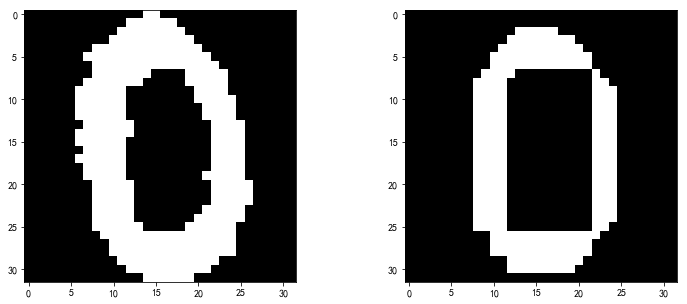

In [31]:
imgCompress(2)

矩阵里包含了一个0字，可以看到重构的矩阵的0变得平整了一些。显然svd是一种有损的压缩，大家要根据需求使用。

# 额外的展示

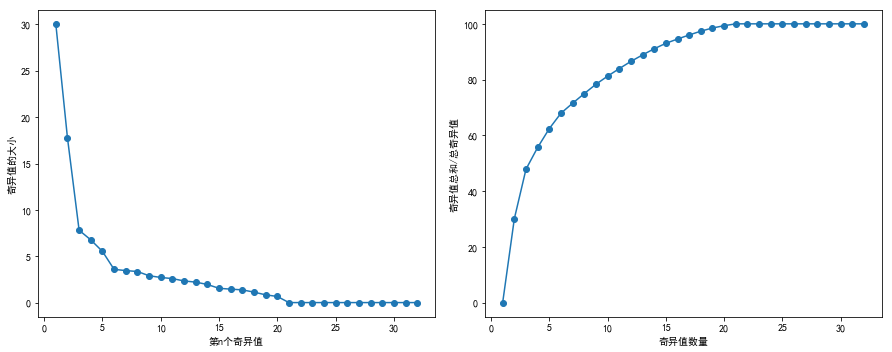

In [32]:
data = loadPicData()
U,Sigma,VT = linalg.svd(data)

total = np.sum(Sigma)
num = Sigma.shape[0]
s_rate = Sigma / total * 100

plt.figure()#创建画布
figsize(12.5, 5)#调整图片大小

plt.subplot(1,2,1)#选择第一块区域
plt.plot(np.arange(1,num+1,1),s_rate,"-o")#画出第一幅图
plt.xlabel("第n个奇异值")
plt.ylabel("奇异值的大小")

plt.subplot(1,2,2)#选择第二块区域
plt.plot(np.arange(1,num+1,1),[np.sum(s_rate[:i]) for i in range(num)],"-o")#画出第二幅图
plt.xlabel("奇异值数量")
plt.ylabel("奇异值总和/总奇异值")

plt.tight_layout()
plt.show()

我们可以看到奇异值大小下降是非常快的，而且前几个奇异值非常大，其包含的信息就越多。

以上便是15章SVD要展示的所有的内容，感谢你的观看。